# Plotting mean ancestor displacements

In [172]:
import numpy as np
from importlib import reload  
# import sparg
# sparg = reload(sparg)
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import time
import tskit

In [173]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [238]:
def map_displacements(sample_locations, mle_locations,
                      highlight_ixs = [], highlight_sample_alpha=1, highlight_arrow_alpha=1, labels=[],
                      projection='cyl',
                      lon_0='auto', lat_0='auto', figsize=(10,12), height=1000,
                      xlims='auto', ylims='auto',
                      all_locations=None, all_alpha=0.1, mean_location=False,
                      log_displacements=False,
                      sample_alpha=0.5, sample_marker='o', 
                      arrows=True, arrow_alpha=0.5, arrow_width=0.1,
                      colorbar=True, colorbartitle=None, pad = -0.09,
                      fname=None, dpi=90, show=True, pad_inches=0):
    'function to plot locations on maps'


    # set up figure
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111, adjustable='box', aspect=1) #square
    
    if projection == 'nsper':
        
        if lon_0 == 'auto':
            lon_0 = np.mean(np.unique(sample_locations[:,1]))
        if lat_0 == 'auto':
            lat_0 = np.mean(np.unique(sample_locations[:,0]))

        bm1 = Basemap(projection=projection, #projection
                     lon_0=lon_0, lat_0=lat_0, #center point
                     satellite_height=height*1000., #height in meters
                     resolution='l') #low?
 
    if projection == 'cyl':
        
        if xlims == 'auto':
            xlims = [min(min(sample_locations[:,1]), min(mle_locations[:,1])) - 1,
                     max(max(sample_locations[:,1]), max(mle_locations[:,1])) + 1]
        if ylims == 'auto':
            ylims = [min(min(sample_locations[:,0]), min(mle_locations[:,0])) - 1,
                     max(max(sample_locations[:,0]), max(mle_locations[:,0])) + 1]        
        
        bm1 = Basemap(projection=projection, 
                llcrnrlon=xlims[0], urcrnrlon=xlims[1], 
                llcrnrlat=ylims[0], urcrnrlat=ylims[1], 
                resolution='l')

    bm1.drawmapboundary(fill_color='lightsteelblue', zorder=0) #fill the globe with a blue color 
    bm1.fillcontinents(color='lightgray',lake_color='lightsteelblue', zorder=1) #continents gray, lakes blue
    bm1.drawcountries(color='gray', zorder=2) #country boundaries to help orient    
    cmap = plt.get_cmap('viridis') #color map for mles

    # plot locations of all samples
    if all_locations is not None:
        ulocs = all_locations # all locations
        xi, yi = bm1(ulocs[:,1], ulocs[:,0]) #on the projection
        ax1.scatter(xi, yi, alpha=all_alpha, color='k', zorder=3)
    
        # plot mean location of samples (eg to see if ancestor different from that)
        if mean_location:
            xi, yi = bm1(np.mean(ulocs[:,1]), np.mean(ulocs[:,0])) #on the projection
            ax1.scatter(xi, yi, alpha=1, color='red', zorder=4)
    
    # calculate displacements to color arrows
    mean_displacements = np.array([haversine(mle[1],mle[0],sample[1],sample[0]) for mle,sample in zip(mle_locations,sample_locations)])
#     mean_displacements = np.sum((mle_locations - sample_locations)**2, axis=1)
    order = np.argsort(mean_displacements) #sort by ascending displacement (so large displacements plotted last for visibility)
    if log_displacements: #to see more of the variation if some high moving outliers
        mean_displacements = np.log(mean_displacements)
    relative_displacements = mean_displacements/max(mean_displacements)
    
    # plot displacements
    plotting_locations = np.array([sample_locations,mle_locations]).swapaxes(0,1) #append sample locations for plotting
    ordered_locations = plotting_locations[order]
    xs, ys = bm1(ordered_locations[:,:,1], ordered_locations[:,:,0]) #long and lat for all nodes and times
    for i,(x,y) in enumerate(zip(xs,ys)): #loop over nodes
        color = cmap(relative_displacements[order[i]])
        alpha0 = sample_alpha
        alpha1 = arrow_alpha
        edgecolors = None
        zorder0 = 5
        zorder1 = 6
        if order[i] in highlight_ixs:
            alpha0 = highlight_sample_alpha
            alpha1 = highlight_arrow_alpha
            edgecolors = 'k'
            zorder0 = 7
            zorder1 = 8
            ax1.annotate(labels[order[i]], xy=(x[0],y[0]), xycoords='data',
                         xytext=(6, 5), textcoords='offset points', ha='center',
                         zorder=9, color='k')
        ax1.scatter(x[0], y[0], alpha=alpha0, color=color, marker=sample_marker, edgecolors=edgecolors, zorder=zorder0)
        if arrows:
            ax1.arrow(x[0], y[0], x[1]-x[0], y[1]-y[0], color=color, alpha=alpha1, width=arrow_width, overhang=0.25,
                      head_width=5*arrow_width, length_includes_head=True, zorder=zorder1) 

    # color bar
    if colorbar:
        cbar = fig.colorbar(cm.ScalarMappable(norm=None, cmap=cmap), ax=ax1, orientation='horizontal', shrink=0.75, pad=pad)
        cbar.set_ticks([i/4 for i in range(5)])
        if log_displacements:
            cbar.set_ticklabels([round(np.exp(i*max(mean_displacements)/4)) for i in range(5)])
        else:
            cbar.set_ticklabels([round(i*max(mean_displacements)/4) for i in range(5)])
        cbar.set_label(colorbartitle, fontsize=14)
        cbar.ax.tick_params(labelsize=14)
        
    plt.tight_layout()

    if fname is not None:
        plt.savefig(fname, dpi=dpi, bbox_inches = 'tight', pad_inches = pad_inches)

    if show:
        plt.show()
    else:
        plt.close()

In [175]:
def filter_samples(locations, group, clusters):

    if group == 'Eurasia':
        not_na = [i for i,j in enumerate(locations) if j[1]>-30] #not in NA (longitude greater than -30), and not missing (since the inequality is false when nan)
    elif group == 'Eurasia-no-Japan':
        not_na = [i for i,j in enumerate(locations) if j[1]>-30 and j[1]<120] #not NA, Japan, or nan
    else:
        print('error: group does not exist!')
        return

    # try to make clusters from pairwise differences  
    #remove = []
    #for cluster in clusters:
    #  remove.append(cluster[1:]) #remove all but first sample in each cluster (a bit of a rough approach)
    #remove = [i for j in remove for i in j] #flatten the list

    # just remove all samples
    remove = np.unique(clusters) #remove all samples that are in a nearly identical pair

    sample_ix = range(len(locations)+1) #index for all samples
    sample_ix_nonidentical = [i for i in sample_ix if i not in remove] #list of nonidentical sample idices
    keep = [i for i in sample_ix_nonidentical if i in not_na] #list of samples to keep

    return keep

parameters

In [176]:
datadir = '../data/'
plotdir = '../plots/'
chromosomes = range(1,6)
twoNe = 170000
u = 7e-09
numiter = 5
threshold = 0.5
nloci = 1000
dCutoff = 1000
tCutoff = 10000
group = 'Eurasia-no-Japan'
tsplits = [10,100,1000]
times = [10,100,1000]

metadata

In [177]:
metadata = pd.read_csv(datadir+'1001G_metadata.csv', header=0)
admixture_groups = np.array(metadata['admixed group'], dtype='str')
country = np.array(metadata['country'], dtype='str')
site = np.array(metadata['site'], dtype='str')
names = np.array(metadata['name'], dtype='str')

locations

In [178]:
locations = np.loadtxt(datadir + '1001G.locs') #locations of samples
clusters = np.load(datadir + '1001G_MAF0.05_dCutoff%d_clusters.npy' %dCutoff, allow_pickle=True) #clusters of nearly identical samples
keep = filter_samples(locations, group, clusters)

data

In [179]:
mean_mles = []
for time in times:

    mle_locations = []
    for chromosome in chromosomes:
        mle_locations.append(np.load(datadir + '1001G_chr%d_2Ne%d_u%s_numiter%d_threshold%.1f_tCutoff%d_dCutoff%d_group%s_tsplits%s_time%d_displacements.npy' %(chromosome,twoNe,u,numiter,threshold,tCutoff,dCutoff,group,tsplits,time)))

    mean_mles.append(np.nanmean(mle_locations, axis=(0,1,2))) #mean over chromosomes and loci (only 1 time so include that dimn too)

## summary plots

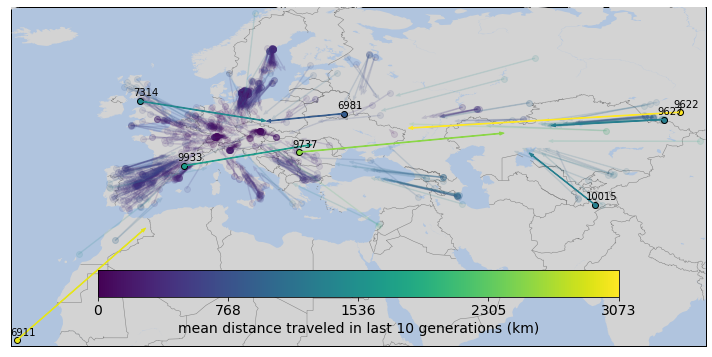

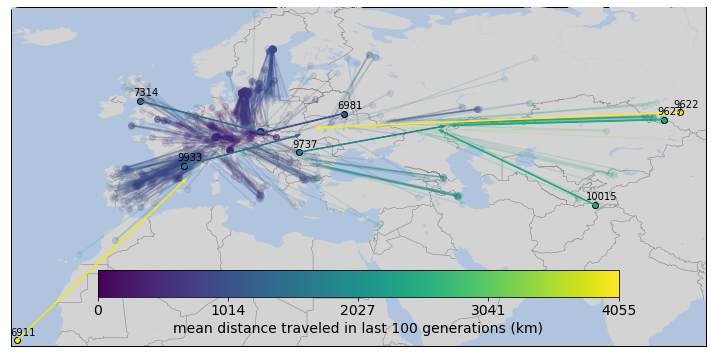

In [239]:
highlight_ixs = [
                 658, #romania
                 577, 658, #russia
    
                 817, #france
                 874, #afghanistan
    
                 320, #uk
                 249, #belarus
    
                 216, #cabo verde
    
                 573, #eastern russia
                ]

labels = [metadata.iloc[ix].accession for ix in keep]

for i,time in enumerate(times[:-1]):
    
    fname = plotdir + '1001G_mean_displacements_time%d.pdf' %time
    if highlight_ixs is not None:
        fname = plotdir + '1001G_mean_displacements_time%d_highlights.pdf' %time
#     fname = None 
        
    colorbartitle='mean distance traveled in last %d generations (km)' %time
    
    map_displacements(sample_locations=locations[keep], mle_locations=mean_mles[i], fname=fname, colorbartitle=colorbartitle,
                      sample_alpha=0.1, arrow_alpha=0.1, highlight_ixs=highlight_ixs, labels=labels)

# outlier investigation

now to explore some of the interesting examples

## eastward Romanian sample

for example, the Romanian sample going east

here is the metadata on the Romanian samples

In [21]:
ixs = [i for i in keep if country[i]=='Romania']
metadata.iloc[ixs]

,accession,name,CS number,country code,latitude,longitude,collector,seq by,continent,country,admixed group,site,GTM axis 1,GTM axis 2,t-SNE axis 1,t-SNE axis 2,Principal component 1,Principal component 2
876,9736,Teiu-2,CS77361,ROU,44.69,25.17,0,Monsanto,Europe,Romania,Admixed,NaN,-0.925450,-0.467034,-31.048489,3.849994,-17.367314,16.829073
877,9737,Ulies-1,CS78815,ROU,45.95,22.62,0,Monsanto,Europe,Romania,Asia,NaN,-0.576466,0.999910,-33.408871,88.976349,-34.182367,103.033964
878,9738,Bran-1,CS76722,ROU,45.57,25.42,0,Monsanto,Europe,Romania,Admixed,NaN,-0.846031,-0.391688,-27.339121,2.461113,-9.755007,-3.947743
879,9739,Toc-1,CS77370,ROU,46.01,22.33,0,Monsanto,Europe,Romania,Central Europe,NaN,-0.890592,-0.360997,-33.029011,8.361842,-18.063620,6.177797
880,9741,Orast-1,CS77151,ROU,45.84,23.16,0,Monsanto,Europe,Romania,Central Europe,NaN,-0.922993,-0.440250,-32.610729,6.822268,-18.635961,12.245350
881,9743,Furni-1,CS76873,ROU,45.14,25.00,0,Monsanto,Europe,Romania,Admixed,NaN,-0.911615,-0.478610,-31.313234,2.242754,-17.314260,15.890538
882,9744,Iasi-1,CS76944,ROU,47.16,27.59,0,Monsanto,Europe,Romania,Admixed,NaN,-0.948019,-0.465666,-32.744221,6.126241,-20.121994,20.303316
1103,10004,Bolin-1,CS76373,ROU,44.46,25.74,NaN,MPI,Europe,Romania,"Italy, Balkan and Caucasus",NaN,-0.912992,-0.458438,-30.617655,2.936718,-15.702254,15.414403
1104,10005,Copac-1,CS76420,ROU,46.11,21.95,NaN,MPI,Europe,Romania,Central Europe,NaN,-0.913214,-0.398141,-32.500778,7.114192,-18.611017,11.024986


so the outlier is likely accession 9737, part of the asia admixture group with the outlier pc2 value

In [29]:
ixs = [i for i,j in enumerate(keep) if country[j]=='Romania'] #index in keep
disps = mean_mles[0][ixs] #displacements
i = np.argmax(disps[:,1]) #which has largest longitude
j = ixs[i]
print(j, keep[j])
metadata.iloc[keep[j]]

658 877


accession                    9737
name                      Ulies-1
CS number                 CS78815
country code                  ROU
latitude                    45.95
longitude                   22.62
collector                       0
seq by                   Monsanto
continent                  Europe
country                   Romania
admixed group                Asia
site                          NaN
GTM axis 1              -0.576466
GTM axis 2                0.99991
t-SNE axis 1             -33.4089
t-SNE axis 2              88.9763
Principal component 1    -34.1824
Principal component 2     103.034
Name: 877, dtype: object

it appears to coalesce with some russian samples <100 generations ago

10


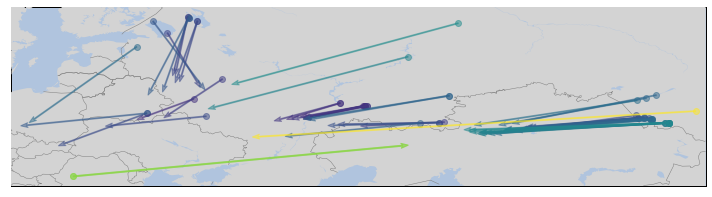

100


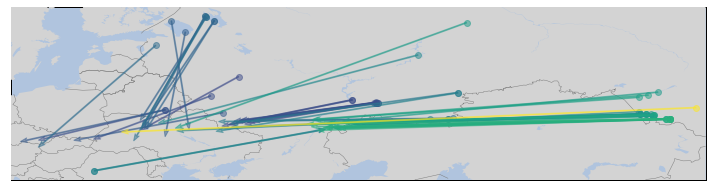

1000


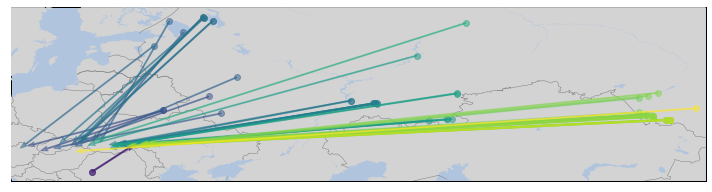

In [42]:
russians = [i for i,j in enumerate(keep) if country[j]=='Russian Federation']
nodes.append(j)

for i,time in enumerate(times):
    print(time)
    fname = None
    colorbartitle='mean distance traveled in last %d generations (km)' %time
    map_displacements(sample_locations=locations[keep][nodes], mle_locations=mean_mles[i][nodes], arrows=True, sample_alpha=0.5, arrow_alpha=0.5, projection='cyl', arrow_width=0.1, log_displacements=False, colorbar=False, fname=fname, colorbartitle=colorbartitle, pad = -0.09)

the metadata on all these Russian samples is

In [44]:
metadata.iloc[[keep[i] for i in russians]]

,accession,name,CS number,country code,latitude,longitude,collector,seq by,continent,country,admixed group,site,GTM axis 1,GTM axis 2,t-SNE axis 1,t-SNE axis 2,Principal component 1,Principal component 2
339,6938,Ms-0,CS76555,RUS,55.7522,37.6322,Albert Kranz,Salk,Europe,Russian Federation,Asia,Ms,-0.984231,0.980019,-31.920443,76.296280,-24.521843,48.112263
363,6981,Ws-2,CS78920,RUS,52.3000,30.0000,Kenneth Feldmann,"MPI,Salk",Europe,Russian Federation,Admixed,Ws,0.967402,-0.210986,7.779467,4.528376,-8.881156,6.188414
392,7072,Chi-0,CS76464,RUS,53.7502,34.7361,Albert Kranz,Salk,Europe,Russian Federation,Admixed,Chi,-0.991495,0.874596,-32.525566,75.877899,-23.424868,41.329929
452,7296,Petergof,CS77170,RUS,59.0000,29.0000,Igor Vizir,Monsanto,Europe,Russian Federation,Central Europe,Petergof,-0.699840,-0.012258,-36.288109,12.229576,-15.247686,-2.600528
472,7347,Stw-0,CS76605,RUS,52.0000,36.0000,Albert Kranz,Salk,Europe,Russian Federation,Central Europe,Stw,-0.962511,-0.417959,-33.984760,5.939014,-22.254721,25.407052
489,7396,Ws-0.2,CS78857,RUS,52.3000,30.0000,Albert Kranz,Mott,Europe,Russian Federation,Central Europe,Ws,-0.728827,-0.088312,-34.275299,6.052715,-20.271325,15.444537
567,8354,Per-1,CS76571,RUS,58.0000,56.3167,Albert Kranz,Salk,Europe,Russian Federation,Asia,Per,-0.948769,0.937023,-32.273365,76.289406,-25.461346,51.315293
761,9607,Panik-1,CS77161,RUS,53.0500,52.1500,0,Monsanto,Europe,Russian Federation,Asia,NaN,-0.868200,0.994141,-30.649895,79.735580,-32.716585,77.740680
762,9608,Karag-2,CS76961,RUS,51.3700,59.4400,0,Monsanto,Europe,Russian Federation,Asia,NaN,-0.858253,0.990587,-31.031570,79.404617,-31.499511,76.117961
763,9609,Adam-1,CS76645,RUS,51.4100,59.9800,0,Monsanto,Europe,Russian Federation,Asia,NaN,-0.840809,0.998568,-31.330742,80.126602,-29.632252,79.175997


(note that the sample which moves the fastest to the west, and starts furthest to the east, is one of three admixed samples)

to get a sense of who the romanian is coalescing with lets load one of the tree sequences and calculate the genealogical nearest neighbors

In [32]:
# choose your chromosome (restart kernel before running another to clear memory)
chromosome = 2 #2 is the smallest
ts = tskit.load('../data/1001G_chr%d_2Ne170000_u7e-09_popsize_numiter5_threshold0.5.trees' %chromosome)

In [34]:
gnns = ts.genealogical_nearest_neighbours([keep[j]], [[j] for i,j in enumerate(keep) if country[j]=='Russian Federation'])

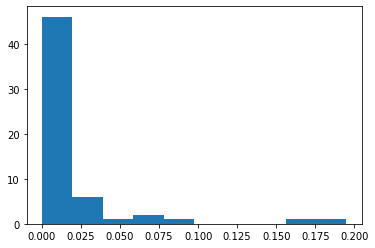

In [35]:
plt.hist(gnns[0])
plt.show()

so it looks like two samples are quite closely related 

In [54]:
neighbours = [j for i,j in enumerate(russians) if gnns[0][i] > 0.15]
metadata.iloc[[keep[i] for i in neighbours]]

,accession,name,CS number,country code,latitude,longitude,collector,seq by,continent,country,admixed group,site,GTM axis 1,GTM axis 2,t-SNE axis 1,t-SNE axis 2,Principal component 1,Principal component 2
778,9627,Kolyv-5,CS76979,RUS,51.32,82.55,0,Monsanto,Europe,Russian Federation,Asia,NaN,-0.667214,0.999672,-32.891163,86.701355,-33.092750,99.580457
781,9630,K-oze-3,CS76958,RUS,51.34,82.16,0,Monsanto,Europe,Russian Federation,Asia,NaN,-0.653884,0.999781,-32.672684,87.396118,-32.108797,97.114021


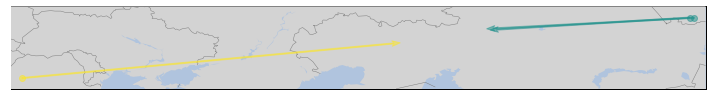

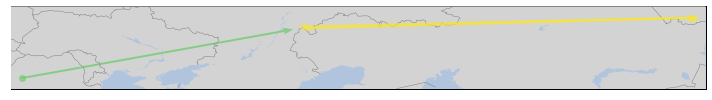

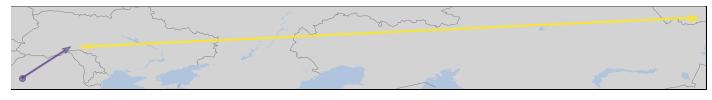

In [56]:
nodes = neighbours
nodes.append(j)

for i,time in enumerate(times):

    fname = None
    colorbartitle='mean distance traveled in last %d generations (km)' %time
    map_displacements(sample_locations=locations[keep][nodes], mle_locations=mean_mles[i][nodes], arrows=True, sample_alpha=0.5, arrow_alpha=0.5, projection='cyl', arrow_width=0.1, log_displacements=False, colorbar=False, fname=fname, colorbartitle=colorbartitle, pad = -0.09)

lets look at the divergence times between the romanian and one of the russians for the chromosome we've loaded

In [78]:
node0 = keep[j]
node1 = keep[neighbours[0]]
metadata.iloc[[node0,node1]]

,accession,name,CS number,country code,latitude,longitude,collector,seq by,continent,country,admixed group,site,GTM axis 1,GTM axis 2,t-SNE axis 1,t-SNE axis 2,Principal component 1,Principal component 2
877,9737,Ulies-1,CS78815,ROU,45.95,22.62,0,Monsanto,Europe,Romania,Asia,NaN,-0.576466,0.999910,-33.408871,88.976349,-34.182367,103.033964
778,9627,Kolyv-5,CS76979,RUS,51.32,82.55,0,Monsanto,Europe,Russian Federation,Asia,NaN,-0.667214,0.999672,-32.891163,86.701355,-33.092750,99.580457


In [ ]:
divs = ts.divergence([[node0],[node1]], mode='branch', span_normalise=True, windows="trees")

../plots/1001G_coalescence-times_nodes[877,778]_chr2.pdf


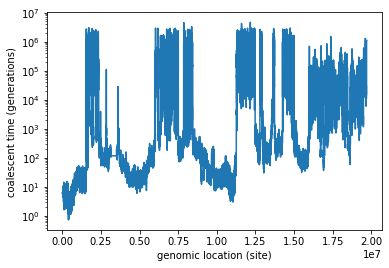

In [81]:
fname = plotdir + '1001G_coalescence-times_nodes[%d,%d]_chr%d.pdf' %(node0,node1,chromosome)
print(fname)

plt.step([i for i in ts.breakpoints()], np.append(divs,divs[-1]))
plt.yscale('log')
plt.xlabel('genomic location (site)')
plt.ylabel('coalescent time (generations)')
plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

## eastward French

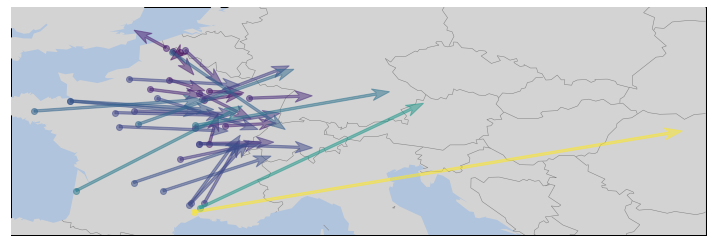

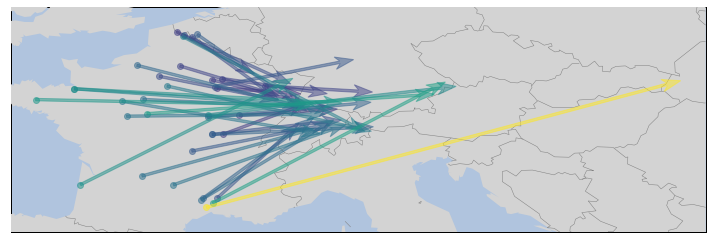

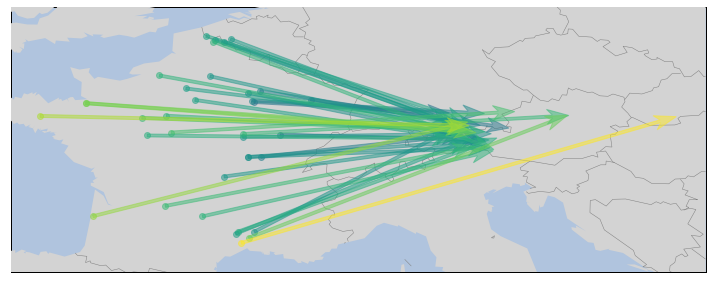

In [83]:
nodes = [i for i,j in enumerate(keep) if country[j]=='France']

for i,time in enumerate(times):

    fname = None
    colorbartitle='mean distance traveled in last %d generations (km)' %time
    map_displacements(sample_locations=locations[keep][nodes], mle_locations=mean_mles[i][nodes], arrows=True, sample_alpha=0.5, arrow_alpha=0.5, projection='cyl', arrow_width=0.1, log_displacements=False, colorbar=False, fname=fname, colorbartitle=colorbartitle, pad = -0.09)

the outlier is

In [84]:
ixs = [i for i,j in enumerate(keep) if country[j]=='France']
mles = mean_mles[-1][ixs] #displacements
i = np.argmax(mles[:,1]) #which has largest longitude
j = ixs[i] #which index in keep is this
print(j,keep[j])
metadata.iloc[keep[j]] #what number sample is this

817 1044


accession                    9933
name                       VED-10
CS number                 CS78839
country code                  FRA
latitude                    43.74
longitude                    3.89
collector                       0
seq by                   Monsanto
continent                  Europe
country                    France
admixed group             Admixed
site                          NaN
GTM axis 1              -0.973932
GTM axis 2              -0.409107
t-SNE axis 1             -32.2597
t-SNE axis 2              3.94956
Principal component 1    -19.6348
Principal component 2     32.7679
Name: 1044, dtype: object

this is admixed, suggesting some distant ancestry. let's see who it's coalescing with from the east (likely the nonrelict)

In [85]:
ixs=[j for i,j in enumerate(keep) if locations[j,1]>50] #samples with longitude > 50
len(ixs)

55

find how related to each of these eastern samples(on this chromosome)

In [88]:
chromosome = 2 #smallest ts
ts = tskit.load('../data/1001G_chr%d_2Ne170000_u7e-09_popsize_numiter5_threshold0.5.trees' %chromosome)

gnns = ts.genealogical_nearest_neighbours([keep[j]], [[i] for i in ixs])

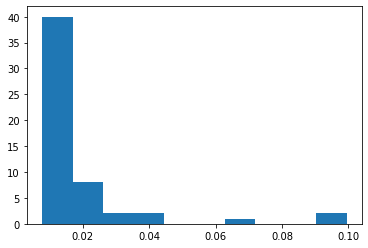

In [90]:
plt.hist(gnns[0])
plt.show()

so closest relative is

In [91]:
metadata.iloc[ixs[np.argmax(gnns)]]

accession                      10015
name                           Ara-1
CS number                    CS76382
country code                     AFG
latitude                       37.29
longitude                       71.3
collector                        NaN
seq by                           MPI
continent                       Asia
country                  Afghanistan
admixed group                   Asia
site                             NaN
GTM axis 1                 -0.595831
GTM axis 2                  0.999956
t-SNE axis 1                -33.2425
t-SNE axis 2                 88.0428
Principal component 1       -34.4041
Principal component 2        102.853
Name: 1113, dtype: object

In [118]:
ixs = [i for i,j in enumerate(keep) if j==1113]

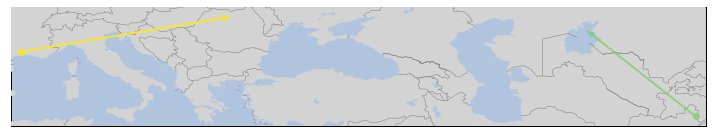

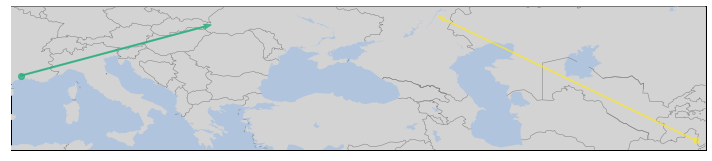

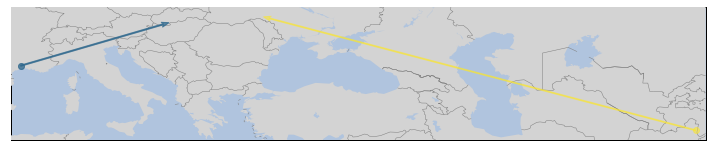

In [126]:
ixs.append(j)

for i,time in enumerate(times):

    fname = None
    colorbartitle='mean distance traveled in last %d generations (km)' %time
    map_displacements(sample_locations=locations[keep][ixs], mle_locations=mean_mles[i][ixs], arrows=True, sample_alpha=0.5, arrow_alpha=0.5, projection='cyl', arrow_width=0.1, log_displacements=False, colorbar=False, fname=fname, colorbartitle=colorbartitle, pad = -0.09)

look at divergence times across this chromosome

In [127]:
node0 = keep[j]
node1 = keep[ixs[0]]
metadata.iloc[[node0,node1]]

,accession,name,CS number,country code,latitude,longitude,collector,seq by,continent,country,admixed group,site,GTM axis 1,GTM axis 2,t-SNE axis 1,t-SNE axis 2,Principal component 1,Principal component 2
1044,9933,VED-10,CS78839,FRA,43.74,3.89,0,Monsanto,Europe,France,Admixed,NaN,-0.973932,-0.409107,-32.259727,3.949559,-19.634776,32.767858
1113,10015,Ara-1,CS76382,AFG,37.29,71.30,NaN,MPI,Asia,Afghanistan,Asia,NaN,-0.595831,0.999956,-33.242531,88.042763,-34.404109,102.853346


In [128]:
divs = ts.divergence([[node0],[node1]], mode='branch', span_normalise=True, windows="trees")

../plots/1001G_coalescence-times_nodes[1044,1113]_chr2.pdf


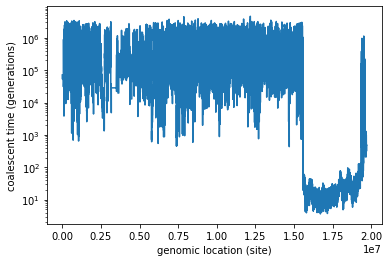

In [129]:
fname = plotdir + '1001G_coalescence-times_nodes[%d,%d]_chr%d.pdf' %(node0,node1,chromosome)
print(fname)

plt.step([i for i in ts.breakpoints()], np.append(divs,divs[-1]))
plt.yscale('log')
plt.xlabel('genomic location (site)')
plt.ylabel('coalescent time (generations)')
plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

## UK - Belarus

another interesting outlier is an apparent coalescence at many loci bteween UK and Belarus

the UK sample is the one that moved furthest east

In [130]:
UKs = [i for i,j in enumerate(keep) if country[j]=='United Kingdom']
uk_mles = mean_mles[0][UKs] #displacements
i = np.argmax(uk_mles[:,1]) #which has largest longitude
j = UKs[i]
print(j,keep[j])
metadata.iloc[keep[j]]

320 457


accession                             7314
name                                Ragl-1
CS number                          CS76583
country code                            UK
latitude                           54.3512
longitude                         -3.41697
collector                Maarten Koornneef
seq by                                Salk
continent                           Europe
country                     United Kingdom
admixed group                      Admixed
site                                  Ragl
GTM axis 1                        0.966673
GTM axis 2                       -0.210499
t-SNE axis 1                       7.78114
t-SNE axis 2                       4.53192
Principal component 1             -9.17594
Principal component 2              6.42499
Name: 457, dtype: object

which has quite a different PC2 than the other UK samples

In [131]:
metadata.iloc[[j for i,j in enumerate(keep) if country[j]=='United Kingdom']]

,accession,name,CS number,country code,latitude,longitude,collector,seq by,continent,country,admixed group,site,GTM axis 1,GTM axis 2,t-SNE axis 1,t-SNE axis 2,Principal component 1,Principal component 2
109,4779,UKSW06-179,CS78808,UK,50.4000,-4.90000,Eric Holub,Monsanto,Europe,United Kingdom,Western Europe,St Columb,0.843574,-0.809598,15.233742,-29.019579,6.306837,-24.850701
110,4807,UKSW06-207,CS78809,UK,50.4000,-4.90000,Eric Holub,Monsanto,Europe,United Kingdom,Western Europe,Indian Queen,0.920433,-0.740376,13.719951,-26.537127,2.830189,-19.737316
111,4826,UKSW06-226,CS78810,UK,50.4000,-4.90000,Eric Holub,Monsanto,Europe,United Kingdom,Western Europe,St Dennis,0.810361,-0.759717,16.918760,-29.077757,2.075982,-29.745548
114,4884,UKSW06-285,CS78811,UK,50.3000,-4.90000,Eric Holub,Monsanto,Europe,United Kingdom,Western Europe,St Stephens,0.669768,-0.962282,20.375906,-32.634834,6.030003,-31.815443
115,4900,UKSW06-302,CS78812,UK,50.3000,-4.80000,Eric Holub,Monsanto,Europe,United Kingdom,Western Europe,St Austel,0.502772,-0.999946,22.765049,-33.978874,6.766525,-35.609671
117,4958,UKSW06-360,CS78814,UK,50.5000,-4.50000,Eric Holub,Monsanto,Europe,United Kingdom,Western Europe,Liskeard,0.883042,-0.834272,14.368348,-28.428877,3.504293,-21.280600
118,5023,UKSE06-118,CS78799,UK,51.3000,0.50000,Eric Holub,Monsanto,Europe,United Kingdom,Western Europe,East Malling Research Station,0.540428,-0.999882,21.531570,-34.129173,5.603500,-33.499191
119,5104,UKSE06-252,CS78800,UK,51.3000,0.50000,Eric Holub,Monsanto,Europe,United Kingdom,Germany,East Malling village,-0.999943,-0.435575,-2.525949,-3.487698,-7.912997,-0.703058
120,5151,UKSE06-325,CS78801,UK,52.2000,-1.70000,Eric Holub,Monsanto,Europe,United Kingdom,Admixed,West Malling village,0.939644,-0.640674,14.503626,-6.983232,8.704943,-16.011464
121,5165,UKSE06-362,CS78802,UK,51.3000,0.40000,Eric Holub,Monsanto,Europe,United Kingdom,Admixed,Wateringbury,0.974000,-0.517416,14.496205,-4.802370,-0.408186,-14.228584


the Belarussian sample is a "Russian" sample that moved furthest west

In [132]:
rus = [i for i,j in enumerate(keep) if country[j]=='Russian Federation']
rus_mles = mean_mles[0][rus] #displacements of russians
i = np.argmin(rus_mles[:,1]) #which has smallest longitude
j = rus[i] #which index in keep is this
print(j,keep[j])
metadata.iloc[keep[j]] #what number sample is this

249 363


accession                              6981
name                                   Ws-2
CS number                           CS78920
country code                            RUS
latitude                               52.3
longitude                                30
collector                  Kenneth Feldmann
seq by                             MPI,Salk
continent                            Europe
country                  Russian Federation
admixed group                       Admixed
site                                     Ws
GTM axis 1                         0.967402
GTM axis 2                        -0.210986
t-SNE axis 1                        7.77947
t-SNE axis 2                        4.52838
Principal component 1              -8.88116
Principal component 2               6.18841
Name: 363, dtype: object

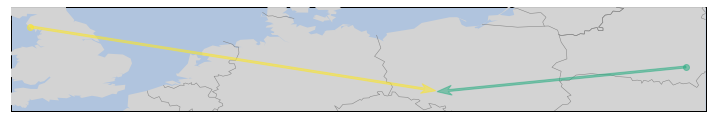

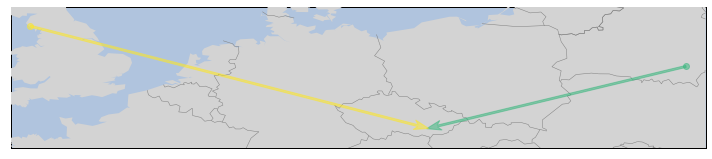

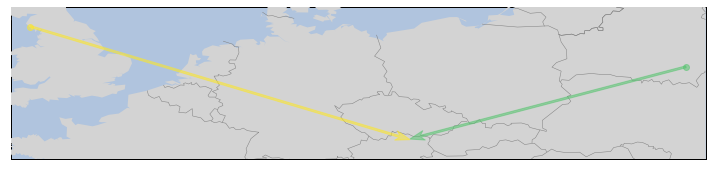

In [134]:
nodes = [320,249]

for i,time in enumerate(times):

    fname = None
    colorbartitle='mean distance traveled in last %d generations (km)' %time
    map_displacements(sample_locations=locations[keep][nodes], mle_locations=mean_mles[i][nodes], arrows=True, sample_alpha=0.5, arrow_alpha=0.5, projection='cyl', arrow_width=0.1, log_displacements=False, colorbar=False, fname=fname, colorbartitle=colorbartitle, pad = -0.09)

this coalescence also appears to be a pair of "identical lines" in fig 3B of 1001G 2016, but they must differ by >1000 SNPs or we'd have filtered them out. let's take a look at the coalescence times to see what is going on

In [135]:
node0 = keep[320]
node1 = keep[249]
metadata.iloc[[node0,node1]]

,accession,name,CS number,country code,latitude,longitude,collector,seq by,continent,country,admixed group,site,GTM axis 1,GTM axis 2,t-SNE axis 1,t-SNE axis 2,Principal component 1,Principal component 2
457,7314,Ragl-1,CS76583,UK,54.3512,-3.41697,Maarten Koornneef,Salk,Europe,United Kingdom,Admixed,Ragl,0.966673,-0.210499,7.781139,4.531920,-9.175940,6.424994
363,6981,Ws-2,CS78920,RUS,52.3000,30.00000,Kenneth Feldmann,"MPI,Salk",Europe,Russian Federation,Admixed,Ws,0.967402,-0.210986,7.779467,4.528376,-8.881156,6.188414


In [136]:
divs = ts.divergence([[node0],[node1]], mode='branch', span_normalise=True, windows="trees")

../plots/1001G_coalescence-times_nodes[457,363]_chr2.pdf


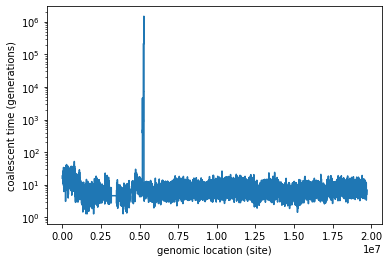

In [137]:
fname = plotdir + '1001G_coalescence-times_nodes[%d,%d]_chr%d.pdf' %(node0,node1,chromosome)
print(fname)

plt.step([i for i in ts.breakpoints()], np.append(divs,divs[-1]))
plt.yscale('log')
plt.xlabel('genomic location (site)')
plt.ylabel('coalescent time (generations)')
plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

so not much divergence on chromosome 2. let's look at the other chromosomes

[restart kernel before loading more tree sequences]

../plots/1001G_coalescence-times_nodes[457,363]_chr5.pdf


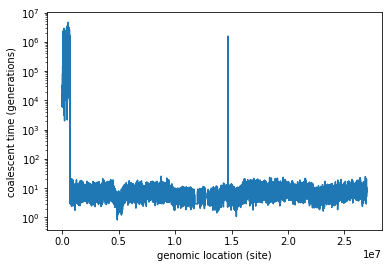

In [4]:
import tskit
import matplotlib.pyplot as plt
import numpy as np

chromosome = 5 #this is the one with some divergence
ts = tskit.load('../data/1001G_chr%d_2Ne170000_u7e-09_popsize_numiter5_threshold0.5.trees' %chromosome)

node0 = 457
node1 = 363
divs = ts.divergence([[node0],[node1]], mode='branch', span_normalise=True, windows="trees")

plotdir = '../plots/'
fname = plotdir + '1001G_coalescence-times_nodes[%d,%d]_chr%d.pdf' %(node0,node1,chromosome)
print(fname)

plt.step([i for i in ts.breakpoints()], np.append(divs,divs[-1]))
plt.yscale('log')
plt.xlabel('genomic location (site)')
plt.ylabel('coalescent time (generations)')
plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

when does the divergence end?

In [7]:
done = 'nope'
i = 0
while done == 'nope':
    if divs[i] < 1000:
        print(i)
        done = 'yep'
    i += 1

1712


In [8]:
i/ts.num_trees

0.034468187854642035

In [9]:
[i for i in ts.breakpoints()][i]

690297.0